# Assignment microscopy

## aims

The assignement is built on pre-filled sections that need to be completed by 
specific assignment tasks

## installation

To run you will need

- skimage

installed. To install, run:

with pip:

```
pip install scikit-image
```

or with conda:
```
conda install scikit-image
```

## warnings 

Make sure MPLBACKEND is not defined as `agg` otherwise you will see no graphical output!
To make sure of this, run the following command before invoking `jupyter lab`:

```sh
export MPLBACKEND=
```

## credits

Marcelo Nollmann, Nov 2021


In [1]:
# loads packages

from tifffile import imsave
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
import imageio
from scipy import ndimage

In [2]:
# loads image
fileName = 'data/Image_nuclei_2D.tif'
img = io.imread(fileName).squeeze()
print("Image read: {}".format(fileName))
print("Image size: {}".format(img.shape))


Image read: data/Image_nuclei_2D.tif
Image size: (2048, 2048)


## Assignment Task 1

- Calculate the distribution of pixel intensity values


In [10]:
from photutils import detect_threshold,detect_sources, Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel

threshold_over_std = 1.0
fwhm = 3.0
area_min = 20

threshold = detect_threshold(img, nsigma=2.0)
sigma_clip = SigmaClip(sigma=fwhm)

bkg_estimator = MedianBackground()
bkg = Background2D(img, (64, 64), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,)
threshold = bkg.background + (
    threshold_over_std * bkg.background_rms
)  # background-only error image, typically 1.0

sigma = fwhm * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

# estimates masks and deblends
segm = detect_sources(img, threshold, npixels=area_min, filter_kernel=kernel,)
print("Done segmenting!")

Done segmenting!


## Assignment Task 2

- Study how segmentation is impacted by fiter_size and by the sigma values. 
- Provide specific images to exemplify extreme cases.


In [9]:
# post-process the binary mask and compute labels
from skimage import filters, measure, morphology

mask=segm.data > 0
area_min = 100
mask = morphology.remove_small_objects(mask, area_min)
mask = morphology.remove_small_holes(mask, area_min)
labels = measure.label(mask)

# calculate object properties
props = measure.regionprops(labels, img)
properties = ['area', 'eccentricity', 'perimeter', 'mean_intensity']
print("Calculated {} properties for {} objects".format(len(properties),labels.max()))

Calculated 4 properties for 573 objects


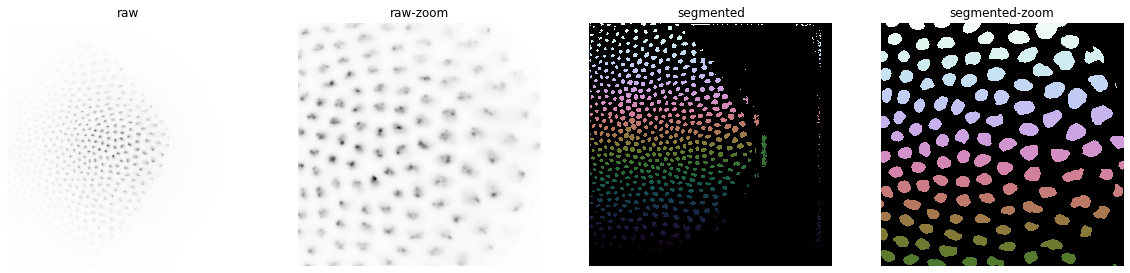

In [5]:
# displays images
cmap = 'cubehelix'
fig, axes = plt.subplots(1, 4)
ax = axes.ravel()
fig.set_size_inches((5*4, 5))

# Cropping
lx, ly = img.shape
zoom = 3
crop_img = img[lx // zoom: - lx // zoom, ly // zoom: - ly // zoom]
crop_segm = segm.data[lx // zoom: - lx // zoom, ly // zoom: - ly // zoom]

ax[0].imshow(img, cmap='Greys')
ax[1].imshow(crop_img, cmap='Greys')
ax[2].imshow(segm.data, origin="lower", cmap=cmap, alpha=1)
ax[3].imshow(crop_segm, origin="lower", cmap=cmap, alpha=1)

subtitles=['raw','raw-zoom','segmented','segmented-zoom']

for axis,subtitle in zip(ax,subtitles):
    axis.set_title(subtitle)
    axis.axis('off')


## Assignment Task 3

- Change colormap so that the color is not encoded by the nuclei position in the image (as in the example above).
- Display examples of segmentations of single nuclei


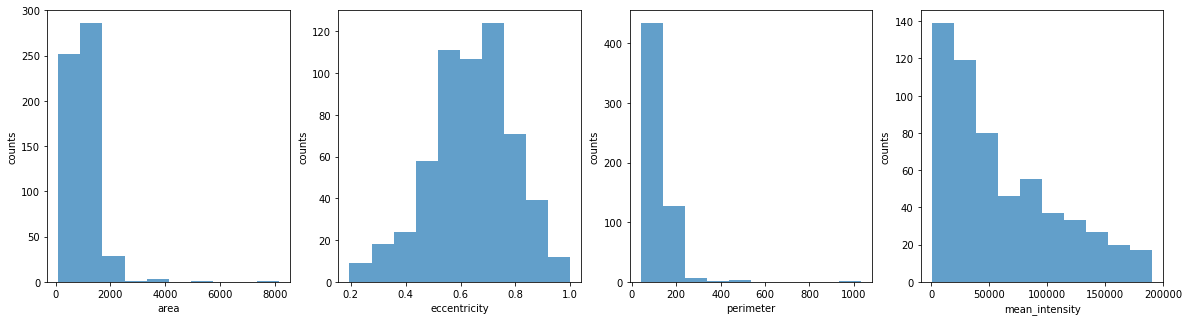

In [6]:
# to code
area=[x.area for x in props]
eccentricity=[x.eccentricity for x in props]
perimeter=[x.perimeter for x in props]
mean_intensity=[x.mean_intensity for x in props]
property_list = [area,eccentricity,perimeter,mean_intensity]

fig, axes = plt.subplots(1, 4)
ax = axes.ravel()
fig.set_size_inches((5*4, 5))

for axis,property_label,property in zip(ax,properties,property_list):
    axis.hist(property,alpha=.7)
    axis.set_xlabel(property_label)
    axis.set_ylabel("counts")


## Assignment Task 4

- Explore how the following parameters affect the statistics of area/ eccentricity/ perimeter and mean_intensity:
    - threshold_over_std = 1.0
    - fwhm = 3.0
    - area_min = 20
- Define and justify the choice of a criterium to determine the best values for these parameters.
